In [118]:
import nltk
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,roc_auc_score, roc_curve
import torch
import transformers
from keras.preprocessing import sequence, text
import tqdm
import sys, os, re, csv, codecs, numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
df = pd.read_csv("/datasets/toxic_comments.csv")

In [5]:
df.drop('Unnamed: 0', axis=1,inplace=True)

In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [22]:
def clear_text(text):
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    return ' '.join(text.split()) 

In [26]:
df['text'] = df['text'].apply(lambda x: clear_text(x))

In [28]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

df['text'] = df['text'].apply(lemmatize_text)

In [29]:
df['toxic'].value_counts(normalize = True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

# ML

In [35]:
RS = 42

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['toxic'], 
                                                                    random_state=RS, 
                                                                    test_size=0.4, 
                                                                    stratify=df['toxic'])


X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                                random_state=RS, 
                                                                test_size=0.5, 
                                                                stratify=y_test)

In [37]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Log Reg

In [39]:
stopwords = 'english'

count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

train_tf_idf = count_tf_idf.fit_transform(X_train) 
test_tf_idf = count_tf_idf.transform(X_test) 
val_tf_idf = count_tf_idf.transform(X_val) 

In [92]:
log_reg = LogisticRegression(C = 2,solver='lbfgs', max_iter=1000)

In [93]:
log_reg.fit(train_tf_idf, y_train)

LogisticRegression(C=2, max_iter=1000)

In [94]:
log_pred = log_reg.predict(val_tf_idf)

In [95]:
f1_score(y_val, log_pred)

0.7500455788514129

## KERAS

In [96]:
BATCH_SIZE = 50
EPOCH = 2
MAXLEN = 250
MAX_FEATURES = 20000
EMBED_SIZE = 128

In [97]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_val = tokenizer.texts_to_sequences(X_val)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [98]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

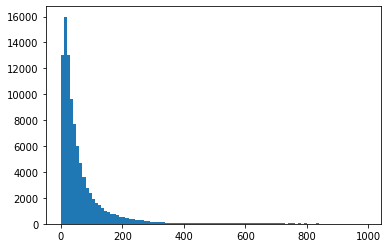

In [99]:
plt.hist(totalNumWords,bins = np.arange(0,1000,10));
plt.show()

In [100]:
xtrain = pad_sequences(list_tokenized_train, maxlen=MAXLEN)
xval = pad_sequences(list_tokenized_val, maxlen=MAXLEN)
xtest = pad_sequences(list_tokenized_test, maxlen=MAXLEN)

In [101]:
inp = Input(shape=(MAXLEN, ))

In [102]:
x = Embedding(MAX_FEATURES, EMBED_SIZE)(inp)

2023-08-08 12:46:59.099149: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [103]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

In [104]:
x = GlobalMaxPool1D()(x)

In [105]:
x = Dropout(0.1)(x)

In [106]:
x = Dense(50, activation="relu")(x)

In [107]:
x = Dropout(0.1)(x)

In [108]:
x = Dense(1, activation="sigmoid")(x)

In [109]:
from keras import backend as K

def f1_scoring(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

In [110]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[f1_scoring])

In [111]:
model.fit(xtrain,y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=0.1)

Epoch 1/2
1721/1721 [==============================] - 1204s 698ms/step - loss: 0.1481 - f1_scoring: 0.6425 - val_loss: 0.0994 - val_f1_scoring: 0.8059
Epoch 2/2
1721/1721 [==============================] - 1181s 686ms/step - loss: 0.0875 - f1_scoring: 0.8072 - val_loss: 0.0997 - val_f1_scoring: 0.8087


In [112]:
pred_val = model.predict(xval)

In [113]:
y_pred_val = (pred_val > 0.5).astype(int)

In [114]:
f1_score(y_val,y_pred_val)

0.8047415212380638

- Результаты работы библиотеки Keras намного лучше логистической регрессии, используем ее на тестовой выборке

In [115]:
pred_test = model.predict(xtest)

In [116]:
y_pred_test = (pred_test > 0.5).astype(int)

In [117]:
f1_score(y_test,y_pred_test)

0.7898089171974522

## Вывод

- С помощью нейросети нам удалось фильтровать сообщения на токсичность проходя необходимый порог, но хочу предположить что модель логистической регрессии хоть и справилась хуже, но при этом сама модель намного проще и быстрее, далее решение нужно принимать исходя из вычислительных мощностей и скорости предсказания. То есть если нам нужна модель которая предсказывает с наибольшей точностью то остановить выбор на keras, но если нам нужна модель которая будет работать в режиме реального времени, а вычислительных мощностей у нас не так много - тогда можно задуматься о том что бы поработать с моделью логистической регрессии.